## Table of contents

1. [The problem domain](#The-problem-domain)
2. [Model architecture](#Model-architecture)
3. [Exploration](#Exploration)
4. [Text preprocessing](#Text-preprocessing)
5. [Define Input output to the model](#Define-Input-output-to-the-model)
6. [Embeddings](#Embeddings)
7. [Define the model](#Define-the-model)
8. [Train the model](#Train-the-model)
9. [Define Inference model](#Define-Inference-model)
10. [Try it](#Try-it)
11. [The most important part](#The-most-important-part)
12. [Further Improvements](#Further-Improvements)


## The problem domain ##
[[ go back to the top ]](#Table-of-contents)

In the modern Internet age, textual data is ever increasing. Need some way to condense this data
while preserving the information and meaning.We need to summarize textual data for that. Text
summarization is the process of automatically generating natural language summaries from an input
document while retaining the important points. It would help in easy and fast retrieval of information.

There are two prominent types of summarization algorithms.

• Extractive summarization systems form summaries by copying parts of the source text
through some measure of importance and then combine those part/sentences together to
render a summary. Importance of sentence is based on linguistic and statistical features.

• Abstractive summarization systems generate new phrases, possibly rephrasing or using
words that were not in the original text. Naturally abstractive approaches are harder. For
perfect abstractive summary, the model has to first truly understand the document and then
try to express that understanding in short possibly using new words and phrases. Much
harder than extractive. Has complex capabilities like generalization, paraphrasing and incorporating real-world knowledge.

Majority of the work has traditionally focussed on extractive approaches due to the easy of defining
hard-coded rules to select important sentences than generate new ones. Also, it promises grammatically correct and coherent summary. But too many rules to keep track of!! Where as an abstraction is an active area of research as they often don’t summarize long and complex texts well


With models like BERT (https://arxiv.org/abs/1810.04805) and Tranformers (https://arxiv.org/abs/1706.03762) the quality of language generation models has improved many folds, which will be explored in the next notebook. But it's essential to understand the drawbacks of seq2seq model as a baseline to be able to appreciate the ideas of improvements in the later models and and thus I have tried it below! :)

 ## Model architecture ##
 [[ go back to the top ]](#Table-of-contents)

The architecture implemented here is similar for the one used in translation cited by https://arxiv.org/pdf/1409.3215.pdf
1. Glove embedding 
2. seq2seq encoder decoder architecture with LSTM layer.


![Image of encoder-decoder architecture ](https://cdn-images-1.medium.com/max/2560/1*nYptRUTtVd9xUjwL-cVL3Q.png)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from sklearn.feature_extraction import stop_words
import re
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys, tarfile
from sklearn.model_selection import train_test_split

from IPython.display import Image

from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer,text_to_word_sequence 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input,Dense, Activation, concatenate, Embedding, Flatten, CuDNNLSTM, Bidirectional, Concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
from keras import optimizers


['kindle-reviews', 'glove-global-vectors-for-word-representation']


Using TensorFlow backend.


For this problem, we are using kindle reviews dataset from kaggle. There are many other features of this dataset which might not be relevant to the problem at hand. The reviewText and summary are used here. The dataset contains approximately million datapoints for us to train model on.

## Exploration ##
[[ go back to the top ]](#Table-of-contents)

In [2]:
kindle_reviews = pd.read_csv('../input/kindle-reviews/kindle_reviews.csv')

In [3]:
kindle_reviews.shape

(982619, 10)

In [4]:
kindle_reviews.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


In [5]:
# Reformatting the dataframe display

pd.set_option('display.max_info_columns',1000)
pd.set_option('display.max_colwidth',5000)
kindle_reviews.drop(columns = ['asin', 'helpful', 'overall', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime'],
                    axis=1, inplace=True)
kindle_reviews.columns = ['index','review', 'summary']
kindle_reviews.set_index(keys = 'index',inplace=True)

Length of the reviews and summary is essential to consider while deciding hyperparameters such as sequence length

In [6]:
# All the model hyperparameters are defined here, considering appropriate percentile of review and summary lengths 

RNN_VOCAB = 10000                           # most frequent 15K words form the vocab 
MAX_SEQUENCE_REVIEW_LENGTH = 22             
MAX_SEQUENCE_SUMMARY_LENGTH = 9
EMBEDDING_DIM = 200                         
EMBEDDING_FILE_PATH = "../input/glove-global-vectors-for-word-representation/glove.6B." + str(EMBEDDING_DIM) + "d.txt"


## Text preprocessing ##
[[ go back to the top ]](#Table-of-contents)

1. lowercasing
2. stop words removal : a new dictionary of stop words is created to preserve the meaning of the original text
3. contractions 
4. punctuations removal
5. Unnecessary white space 


In [7]:

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}


def clean_text(text,remove_stopwords = True, max_len = 20):
    '''
    Given a text this function removes the punctuations, selected stopwords(because not, none convey some meaning and
    removing these stop words changes the meaning of the sentence.) and returns the length of the remaining text string
    '''
    refined_stop_words = {}
    if(remove_stopwords == True):
        refined_stop_words = stop_words.ENGLISH_STOP_WORDS-{ "not","none","nothing","nowhere","never",
                                                        "cannot","cant","couldnt","except","hasnt",
                                                        "neither","no","nobody","nor","without"
                                                           }
    try:
        #convert to lower case and strip regex
        new_text = []
        text = text.lower()
        count = 0
        for word in text.split():
            if word in refined_stop_words:
                continue
            count += 1
            if word in contractions: 
                new_text = new_text + [contractions[word]]
            else: 
                new_text = new_text + [word]
        new_text = new_text[0:max_len] if count>max_len else new_text
        text = ' '.join(new_text)
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        text = regex.sub(" ", text)
        text = re.sub('\s+', ' ', text).strip()
        text = '<start> ' + text + ' <end>'
        return text
    except:
        return ""

In [8]:
kindle_reviews['summary'] = kindle_reviews.summary.apply(lambda x: clean_text(x, True, MAX_SEQUENCE_SUMMARY_LENGTH-2))
kindle_reviews['review'] = kindle_reviews.review.apply(lambda x: clean_text(x, True, MAX_SEQUENCE_REVIEW_LENGTH-2))

In [9]:
kindle_reviews.head()

,review,summary
index,,
0,<start> enjoy vintage books movies enjoyed reading book plot unusual do not think killing self defense leaving scene body without notifying police hitting <end>,<start> nice vintage story <end>
1,<start> book reissue old one author born 1910 it is era of say nero wolfe introduction quite interesting explaining author he is forgotten <end>,<start> different <end>
2,<start> fairly interesting read old style terminology i glad read story does not coarse crasslanguage read fun relaxation i like free ebooksbecause check writer <end>,<start> oldie <end>
3,<start> i would never read amy brewster mysteries one really hooked now <end>,<start> really liked it <end>
4,<start> like period pieces clothing lingo enjoy mystery author guessing 2 3 way through <end>,<start> period mystery <end>


In [10]:
kindle_reviews.shape

(982619, 2)

In [11]:
kindle_reviews['summary_length'] = kindle_reviews.summary.apply(lambda x: len(x.split()))
kindle_reviews['review_length'] = kindle_reviews.review.apply(lambda x: len(x.split()))

count    982619.000000
mean         20.912209
std           4.185922
min           0.000000
25%          19.000000
50%          22.000000
90%          25.000000
95%          26.000000
99%          28.000000
max         161.000000
Name: review_length, dtype: float64


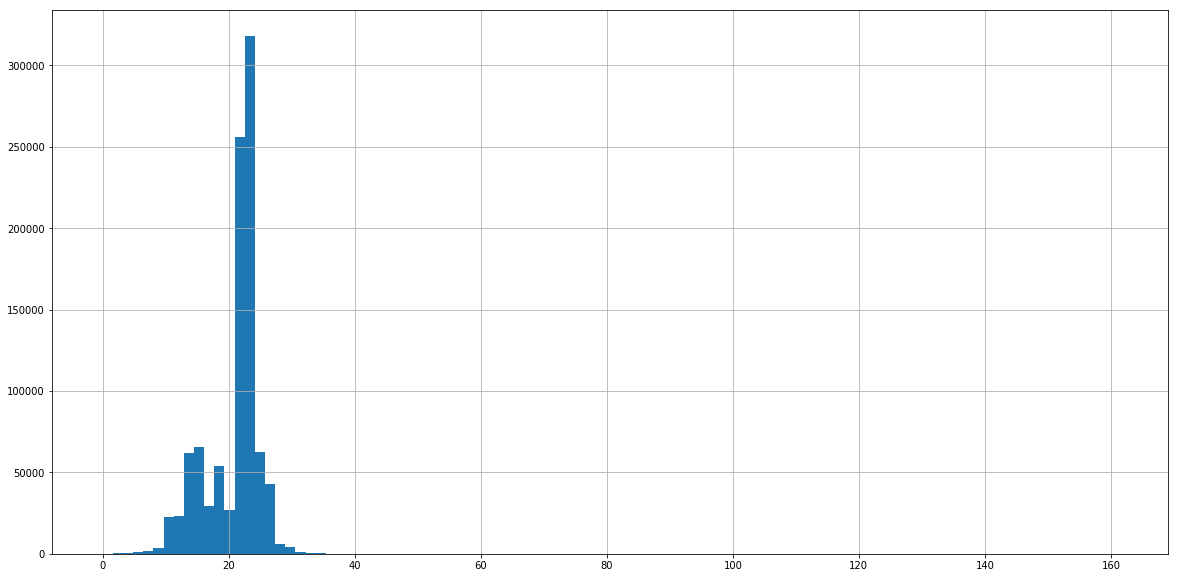

In [12]:
print(kindle_reviews.review_length.describe(percentiles = [0.25, 0.9, 0.95, 0.99]))
kindle_reviews.review_length.hist(bins = 100,figsize = (20,10))

count    982619.000000
mean          4.744101
std           1.575008
min           0.000000
50%           4.000000
90%           7.000000
95%           8.000000
99%           9.000000
max          39.000000
Name: summary_length, dtype: float64


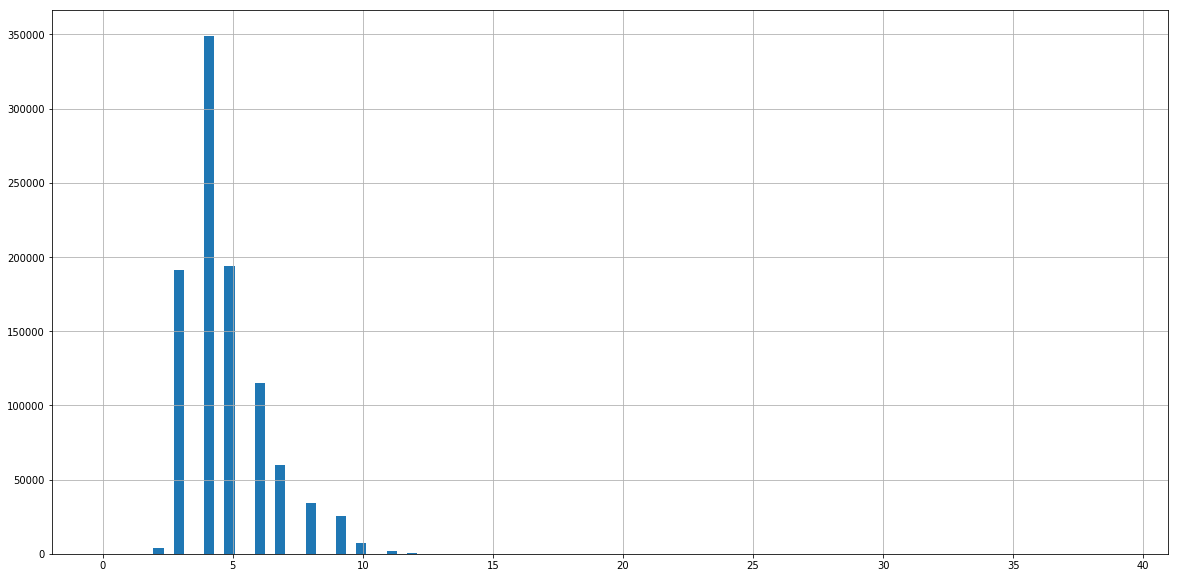

In [13]:
print(kindle_reviews.summary_length.describe(percentiles = [0.9,0.95,0.99]))
kindle_reviews.summary_length.hist(bins = 100,figsize = (20,10))

## Define Input output to the model ## 
[[ go back to the top ]](#Table-of-contents)

Dataset is fairly large for the available processing time. Thus we will be training in batches. 

Let's tokenize this data using keras tokenizer API 

In [14]:
tokenize = Tokenizer(num_words = RNN_VOCAB, oov_token='OOV', filters = '')
tokenize.fit_on_texts(np.hstack([kindle_reviews['summary'],kindle_reviews['review']]))
kindle_reviews['sequence_summary'] = tokenize.texts_to_sequences(kindle_reviews['summary'])
kindle_reviews['sequence_review'] = tokenize.texts_to_sequences(kindle_reviews['review'])

In [15]:
print("Total number of unique words = ", len(tokenize.word_index))

Total number of unique words =  174016


Although there are 291K unique words in the dataset, due to constraints we are using, the most frequent 10K words to form our vocab. In short, 174K tokens would be treated as unknown words and hence, many times our model will tend to be biased to generate UNK token just cause of it's sheer frequency in the dataset, considering it to be more probable.

One way is to remove the samples having OOV token, which is commented below

In [16]:
#reviews = kindle_reviews.loc[kindle_reviews['sequence_summary'].apply(lambda x: not(1 in x))]
#reviews = kindle_reviews.loc[kindle_reviews['sequence_review'].apply(lambda x: not(1 in x))]

The decoder input, should have a start and end token, and thus we add it to our vocab

Every encoder, decoder input - summary is augmented with '<start\>' and preceeded by '<end\>' 

In [17]:
#craeting dataset for the model input output
dataset = {}
dataset['decoder_input'] = pad_sequences(kindle_reviews.sequence_summary, maxlen = MAX_SEQUENCE_SUMMARY_LENGTH, padding='post')
kindle_reviews['sequence_summary'] = kindle_reviews.sequence_summary.apply(lambda x: x[1:])
dataset['decoder_output'] = pad_sequences(kindle_reviews.sequence_summary, maxlen = MAX_SEQUENCE_SUMMARY_LENGTH-1, padding='post')
dataset['encoder_input'] = pad_sequences(kindle_reviews.sequence_review, maxlen = MAX_SEQUENCE_REVIEW_LENGTH, padding='pre')

In [18]:
dataset['decoder_output'].shape, dataset['decoder_input'].shape, dataset['encoder_input'].shape

((982619, 8), (982619, 9), (982619, 22))

In [19]:
dataset['encoder_input'][0:2]

array([[6739,   20, 1871,   26,   22,    4,   75,  943,   44,    6,   52,
        1647,  364, 5845, 1108,  576,  618,  203,    1, 1246, 3933,    3],
       [   1,  152,   59,   23, 1337,    1,   12,   21, 1899,  736,   51,
        9802, 4205,  693,  178,   40, 1991,   23,  298,   21, 2410,    3]],
      dtype=int32)

In [20]:
kindle_val_reviews = kindle_reviews.loc[1000:1005,:].copy()
gc.collect()

0

## Embeddings ##
[[ go back to the top ]](#Table-of-contents)

In [21]:
class Embeddings:
    """
    When a corpus is passed, remove the words which are not in the global vocab(glove) and use most frequent vocab_size
    number of words. 
    """
    def __init__(self, embedding_dim, vocab_size):
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
    def readEmbeddings(self, filePath):
        """
        Given a filepath of word embeddings creates and returns a dictionary of word, embedding values
        """
        # Create a dictionary for storing all {word, embedding values}
        wordToEmbeddingDict = {}
        # open the file as read only
        file = open(filePath, encoding='utf-8')
        # read all text
        for line in file:
            lineValue = line.split()
            word = lineValue[0]
            embedding = np.asarray(lineValue[1:],dtype = 'float32')
            wordToEmbeddingDict[word] = embedding
        # close the file
        file.close()
        return wordToEmbeddingDict
    
    def indexToEmbedding(self, wordToIndexDict, wordToEmbeddingDict):
        indexToEmbeddingMatrix = np.zeros((self.vocab_size, self.embedding_dim))
        for word, index in wordToIndexDict.items():
            if index >= self.vocab_size:
                break
            if word in wordToEmbeddingDict.keys():
                indexToEmbeddingMatrix[index] = wordToEmbeddingDict[word]
            else:
                indexToEmbeddingMatrix[index] = np.array(np.random.uniform(-1.0, 1.0, self.embedding_dim))
        return indexToEmbeddingMatrix
    
    def indexToWord(self, wordToIndexDict):
        return {index: word for word, index in wordToIndexDict.items()}

In [22]:
embeddings = Embeddings(EMBEDDING_DIM, RNN_VOCAB)
wordToEmbeddingDict = embeddings.readEmbeddings(EMBEDDING_FILE_PATH)

indexToEmbeddingMatrix = embeddings.indexToEmbedding(tokenize.word_index, wordToEmbeddingDict)

In [23]:
indexToWordDict = embeddings.indexToWord(tokenize.word_index)

In [24]:
indexToEmbeddingMatrix.shape

(10000, 200)

## Define the model ##
[[ go back to the top ]](#Table-of-contents)

Just to give you an idea of the complexity of this problem, consider the following:
our model outputs probability of each word in the vocab (10K) probabilities, for each timestep.
The number of timesteps for decoder are 9. and we have 982K datapoints. To store the decoder output at training step, we would require (982K \* 9 \* 10K) float value memory,Thus it's inefficient to be training the model, on the entire dataset. 

In such cases fit_generate method of keras comes handy. We can create batches of the input and output as the model trains and the previous batch is discarded at every step of the epoch! It's implemented below

### 1. Helper methods ###

In [25]:
BATCH_SIZE = 2096
NUM_EPOCHS = 15
STEPS_PER_EPOCH = 150
LATENT_DIM = 512                           # Dimensions of LSTM output

In [26]:
def get_batch_data(dataset, start, end):
    # Decoder output will be one hot encoded values 
    # dimensions of the decoder output will be (number of samples * summary length * vocab size)
    assert start < end
    assert end <= dataset['encoder_input'].shape[0]
    encoder_batch_input = dataset['encoder_input'][start:end]
    decoder_batch_input = dataset['decoder_input'][start:end]
    decoder_batch_output = np.zeros(((end-start), MAX_SEQUENCE_SUMMARY_LENGTH, RNN_VOCAB), dtype = 'float16')
    for k, row in enumerate(dataset['decoder_output'][start:end]):
        for i,value in enumerate(row):
            if value!=0:
                decoder_batch_output[k, i, value] = 1
    return encoder_batch_input, decoder_batch_input, decoder_batch_output

In [27]:
#This generate method loops indefinitely on our dataset to create training batches
def generate_batch_data(dataset):
    size = dataset['encoder_input'].shape[0]
    while True:
        start = 0
        end = start+BATCH_SIZE
        while True:
            # create numpy arrays of input data
            # and labels, from each line in the file
            if start>=size:
                break
            encoder_batch_input, encoder_batch_output, decoder_batch_output = get_batch_data(dataset, start, end)
            start = end
            end = np.min([end+BATCH_SIZE, size])
            yield ({'review': encoder_batch_input, 
                    'summary': encoder_batch_output},
                   {'decoder_dense_layer': decoder_batch_output})


### 2 Encoder Decoder



In [28]:
review_input_layer = Input(shape=(MAX_SEQUENCE_REVIEW_LENGTH, ), name = 'review')
embedding_encoder_layer = Embedding(input_length = MAX_SEQUENCE_REVIEW_LENGTH,
                          input_dim = RNN_VOCAB,
                          output_dim = EMBEDDING_DIM,
                          #weights=[indexToEmbeddingMatrix],
                          trainable = False,
                          name = 'embedding_encoder',
                          )
embedding_review_output = embedding_encoder_layer(review_input_layer)
encoder_lstm_layer = Bidirectional(CuDNNLSTM(LATENT_DIM, return_state=True, name = 'lstm_encoder'), merge_mode = 'concat')
_, forward_h, forward_c, backward_h, backward_c = encoder_lstm_layer(embedding_review_output)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]


summary_input_layer = Input(shape=(MAX_SEQUENCE_SUMMARY_LENGTH, ), name = 'summary')
embedding_decoder_layer = Embedding(#input_length = MAX_SEQUENCE_SUMMARY_LENGTH,
                          input_dim = RNN_VOCAB,
                          output_dim = EMBEDDING_DIM,
                          #weights=[indexToEmbeddingMatrix],
                          trainable=False,
                          name = 'embedding_decoder',
                          )
embedding_summary_output = embedding_decoder_layer(summary_input_layer)
decoder_lstm_layer = CuDNNLSTM(2*LATENT_DIM, return_state=True, return_sequences = True, name = 'lstm_decoder')
decoder_output, decoder_h, decoder_c = decoder_lstm_layer(embedding_summary_output,
                                                   initial_state = encoder_states)

decoder_dense_layer = Dense(RNN_VOCAB, activation="softmax", name='decoder_dense_layer')
decoder_dense_output =  decoder_dense_layer(decoder_output)

model = Model([review_input_layer, summary_input_layer], decoder_dense_output) 
sgd = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

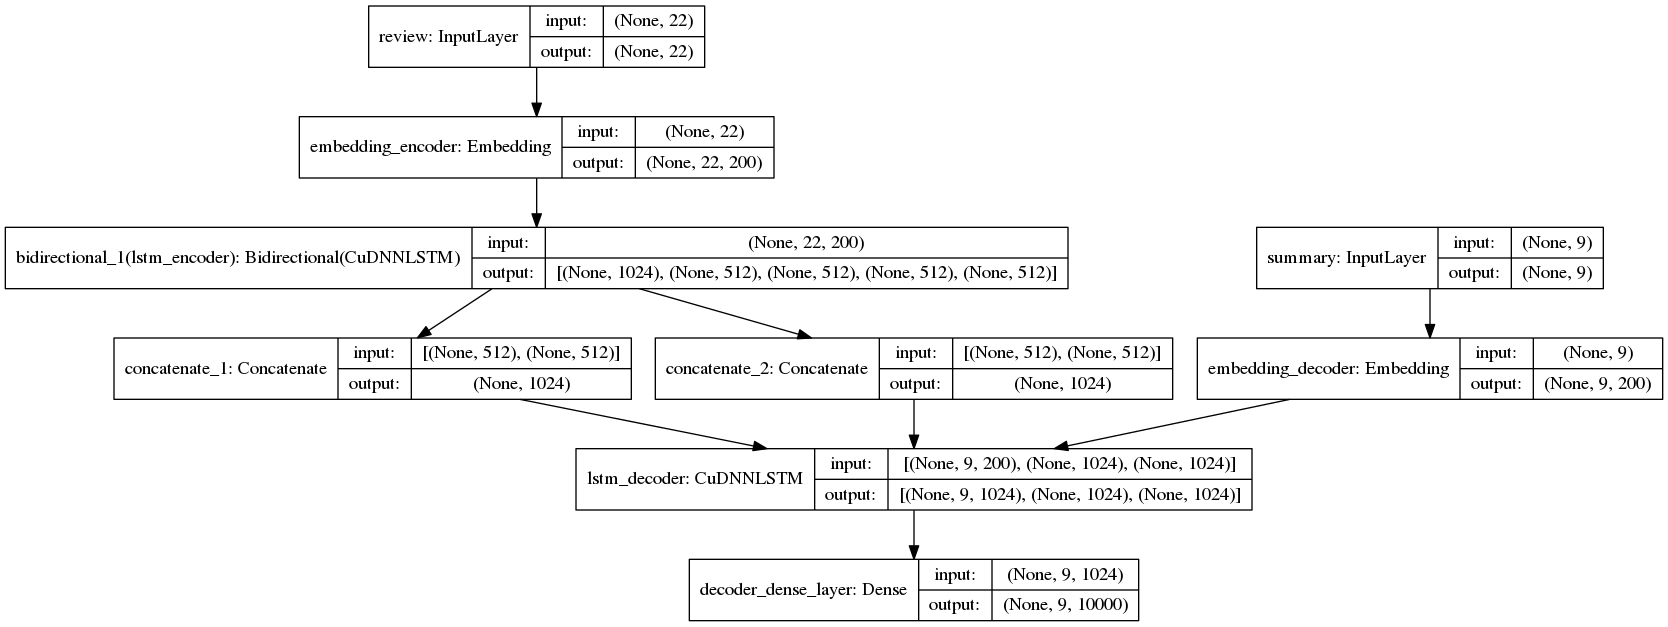

In [29]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png') 

## Train the model ##
[[ go back to the top ]](#Table-of-contents)

In [30]:
model.fit_generator(generator = generate_batch_data(dataset),use_multiprocessing=True,
                    epochs=NUM_EPOCHS, steps_per_epoch = dataset['encoder_input'].shape[0]//BATCH_SIZE)

Epoch 1/15
468/468 [==============================] - 1353s 3s/step - loss: 2.1446
Epoch 2/15
468/468 [==============================] - 1321s 3s/step - loss: 2.0220
Epoch 3/15
468/468 [==============================] - 1325s 3s/step - loss: 1.9499
Epoch 4/15
468/468 [==============================] - 1326s 3s/step - loss: 1.9037
Epoch 5/15
468/468 [==============================] - 1325s 3s/step - loss: 1.8692
Epoch 6/15
468/468 [==============================] - 1324s 3s/step - loss: 1.8404
Epoch 7/15
468/468 [==============================] - 1344s 3s/step - loss: 1.8150
Epoch 8/15
468/468 [==============================] - 1338s 3s/step - loss: 1.7911
Epoch 9/15
468/468 [==============================] - 1368s 3s/step - loss: 1.7688
Epoch 10/15
468/468 [==============================] - 1336s 3s/step - loss: 1.7470
Epoch 11/15
468/468 [==============================] - 1368s 3s/step - loss: 1.7258
Epoch 12/15
468/468 [==============================] - 1325s 3s/step - loss: 1.7046
E

In [31]:
#Always save your weights
model.save_weights('summarization_weights.h5')

In [32]:
model.load_weights('summarization_weights.h5')

In the inference model, we need to keep in mind following few things

First we will encode the sequence, the encoder's output is of no use thus it will be discarded, state_c and state_h of the last timestep will be used as initial state of decoder, same as training. 

Also decoder will receive one input of initial time step ('<start\>' token to get started)

Decoder inputs : [encoder states , <start\>]

1) decoder RNN will output one word at a time,(output dim :{ 1, 1, RNN_VOCAB}

2) from argmax index to word mapping could be used to find the output word,

For the next timestep we need the decoder's states as well as an output of decoder LSTM

3) Next we need to provide our decoder with the decoder states and the output word again

We need to encapsulate decoder in separate block, is because it is gonna run recursively


## Define Inference model ##
[[ go back to the top ]](#Table-of-contents)

Like training we have 2 separate models for encoder and decoder. 
#### Encoder
From encoder we extract the thought vector to feed to the decoder.

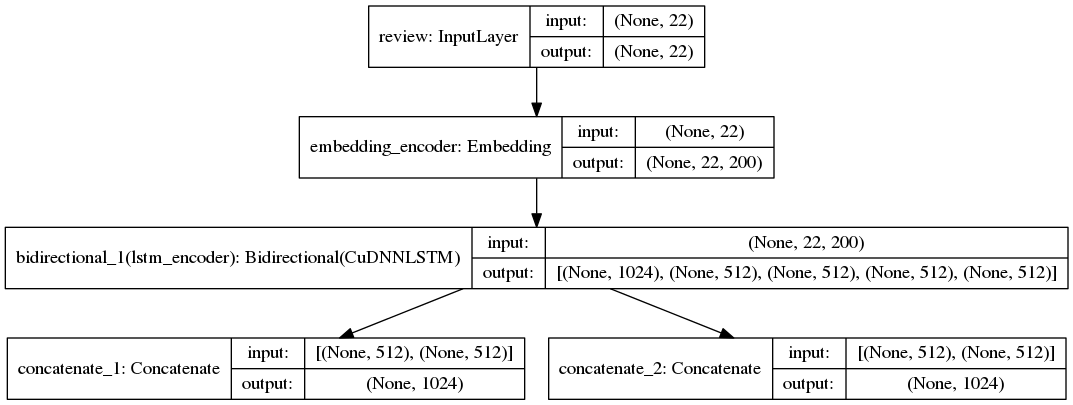

In [33]:
# Define inference model
encoder_inference_model = Model(review_input_layer, encoder_states)
plot_model(encoder_inference_model, to_file='inference_encoder.png', show_shapes=True)

Image(filename='inference_encoder.png') 

 #### Decoder
- 3 inputs to the decoder are, previous time step hidden state, previous time step cell state and input at current timestep
- For first time step we have though vector as, hidden state and cell state as inputs from previous time step
- After that, decoder cell is called recursively

In [34]:
#Exactly same decoder model is used with different input and output adjustments

decoder_state_input_h = Input(shape=(2*LATENT_DIM,))  # These states are required for feeding back to our next timestep decoder
decoder_state_input_c = Input(shape=(2*LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#Now we shall reuse our decoder
summary_for_decoder = Input(shape=(1,))
embedding_summary_decoder = embedding_decoder_layer(summary_for_decoder)

decoder_inference_output, decoder_states_c, decoder_states_h = decoder_lstm_layer(embedding_summary_decoder, initial_state = decoder_states_inputs)
decoder_states_outputs = [decoder_states_c, decoder_states_h]
output_prob = decoder_dense_layer(decoder_inference_output)
decoder_inference_model = Model(
    [summary_for_decoder] + decoder_states_inputs,
    decoder_states_outputs + [output_prob])

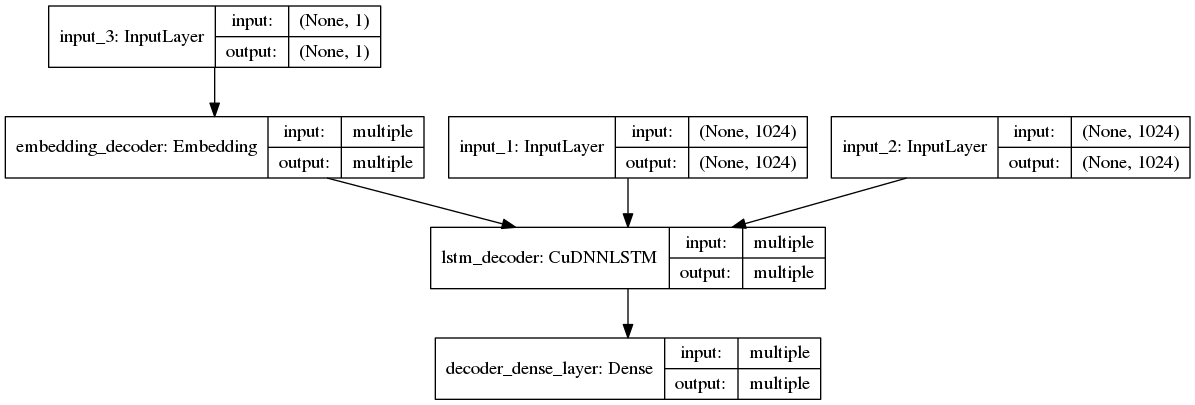

In [35]:
plot_model(decoder_inference_model, to_file='inference_decoder.png', show_shapes=True)

Image(filename='inference_decoder.png') 

In [36]:
def decode_sequence(input_sequence):
    # Encode the input as state vectors. states_h and states_c for decoder init
    encoder_states_value = encoder_inference_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1, for decoder input  
    # Populate the first character of target sequence with the start character.
    target_sequence = np.zeros((1,1))
    target_sequence[0,0] = tokenize.word_index['start']
    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = []
   
    while not stop_condition:
      
        h, c, output_tokens = decoder_inference_model.predict([target_sequence] + encoder_states_value,batch_size=1)
        # Sample a token
        
        sampled_word_index = np.argmax(output_tokens)#np.random.choice(np.arange(10003), p=output_tokens.flatten())
        if sampled_word_index == 0:
            decoded_sentence += ['<pad>']
            continue
        sampled_word = indexToWordDict[sampled_word_index]
        decoded_sentence += [sampled_word]
        
        # Exit condition: either hit max length=
        # or find stop character.
        if (sampled_word == 'end' or
           len(decoded_sentence) > MAX_SEQUENCE_SUMMARY_LENGTH):
            stop_condition = True

        # Update the target sequence (of length 1).
            target_sequence[0, 0] = sampled_word_index
        # Update states
        encoder_states_value = [h, c]
    return ' '.join(decoded_sentence)

## Try it ##
[[ go back to the top ]](#Table-of-contents)

In [37]:
def summarize(input_seq):
    input_seq = pad_sequences(tokenize.texts_to_sequences([clean_text(input_seq)]),MAX_SEQUENCE_REVIEW_LENGTH)
    return decode_sequence(input_seq)

In [38]:
summarize("The book was very nice, will read it again")

'stars finish finish finish it it <end> <end> <end> <end>'

In [39]:
summarize("very very bad book, didn't like it much")

'stars finish finish finish finish interest interest new <end> <end>'

In [40]:
# Try if it's overfitting
for index,row in kindle_val_reviews.head(5).iterrows():
    print("Input review : " , row.review)
    print("Expected review : ", row.summary)
    print("Predicted output : ", summarize(row.review))
    print("\n")

Input review :  <start> stephanie bond new favorite author really great bringing story keeping hanging end hard books start <end>
Expected review :  <start> really great book hillarious <end>
Predicted output :  new new new new new new series <end> <end> <end>


Input review :  <start> stephanie bond writes funny romances easy read funny enjoyable story stephanie bond reader <end>
Expected review :  <start> naughty nice <end>
Predicted output :  funny funny new series s sleep loved it <end> <end>


Input review :  <start> stephanie bond excellent author enjoy romantic comedy added list favorite authors books delightfully humorous hope continues tickle funny bones years <end>
Expected review :  <start> reading delightful <end>
Predicted output :  great new new new series new series <end> <end> <end>


Input review :  <start> stephanie bond entertaining never unnecessary descriptive sex tells good story without junk <end>
Expected review :  <start> good christmastime read <end>
Predicted

## The most important part ##
[[ go back to the top ]](#Table-of-contents)

What did I learn and improvements!
1. Can't expect results without considerable number of epochs and good sized data, for this problem.
For NMT, many small datasets have proven to generate decent translation with the same architecture, cause at the end of the day it's a bit simpler problem where one to one mapping of token from one language to other is possible. In abstractive summarization, it cant be done.
2. OOV, <start\> and <end\> could be mostly generated and it can be safely concluded that the model has learnt to give these words higher importance/ more probability score simply cause they occur almost in every sentence. This doesn't mean model is incorrectly implemented, but simply it needs to be trained on more data and for more epochs
3. During the implementation of the LSTMs, using CUDNNLSTM makes more sense as it's faster in computations
4. Longer sentences, need to be avoided for this problem as LSTMs could easily run into vanishing gradient problem
5. If batch_size is known in advance, stateful lstms could be implemented and it improves performance marginally
6. Bidirectional wrapper returns 5 outputs, lstms output, the forward and backward hidden and cell states. The unused variables should not be names to save memory
7. Hyperparameters that seem to have considerable impact: 
    1. batch_size
    2. learning rate
    3. lstm units/ size of context vector
    4. number of epochs
8. Using categorical cross entropy could potentially save a lot of memory instead of one hot encoding of decoder's softmax output

When same model was trained on NMT problem for 1 epoch and small dataset, it generated, repeating words and additional training improved performance greatly. Thus it's safe to conclude that given more time and data, this model could generate better summaries!

## Further Improvements ##
[[ go back to the top ]](#Table-of-contents)

- implementation of a pipeline for pre-processing text data
- attention mechanism
- beam search
- seq2seq-vis by IBM